# Research and Data Analysis - Red Wine Data

We use the file ‘red_wine_data.csv’. \
This dataset is related to red variant of the Portuguese "Vinho Verde" wine. \
Only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no
data about grape types, wine brand, wine selling price, etc.). \
The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones).

Input variables (based on physicochemical tests):\
1 - fixed acidity\
2 - volatile acidity\
3 - citric acid\
4 - residual sugar\
5 - chlorides\
6 - free sulfur dioxide\
7 - total sulfur dioxide\
8 - density\
9 - pH\
10 - sulphates\
11 - alcohol

Output variable (based on sensory data):\
12 - quality (score between 0 and 10)

My task is to analyse the data and present my findings during the interview.\
I may take a descriptive approach and think about potential ways to present the data, or to
apply any statistical technique to the data to answer a research question that I think can
be answered with this data.

[Reference](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377):
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining
from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [1]:
# libraries
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
#
from collections import Counter
from functools import partial
from scipy.stats import pearsonr, spearmanr, t
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, KFold, train_test_split, ParameterGrid
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.class_weight import compute_class_weight
from skorch import NeuralNetRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBRegressor
#
import torch

In [2]:
# functions
def calculate_smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def calculate_mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

# parameters
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)
test_size = 0.2
tolerance = 0.5
num_runs = 20
confidence_level = 0.95
degrees_of_freedom = num_runs - 1

## 1. Descriptive Analysis

In [3]:
df=pd.read_csv(r'red_wine_data/red_wine_data.csv')
df

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
# define variable types
numeric = [
    'fixedAcidity',
    'volatileAcidity',
    'citricAcid',
    'residualSugar',
    'chlorides',
    'freeSulfurDioxide',
    'totalSulfurDioxide',	
    'density',
    'pH',
    'sulphates',
    'alcohol',
           ]
categorical = [
    'quality'
]

In [5]:
# check nans and infs
for col in numeric:
    print(f"{col} nan values: {np.isnan(df[col]).sum()}")
    print(f"{col} inf values: {np.isinf(df[col]).sum()}")
for col in categorical:
    print(f"{col} nan values: {np.isnan(df[col]).sum()}")
    print(f"{col} inf values: {np.isinf(df[col]).sum()}")

fixedAcidity nan values: 0
fixedAcidity inf values: 0
volatileAcidity nan values: 0
volatileAcidity inf values: 0
citricAcid nan values: 0
citricAcid inf values: 0
residualSugar nan values: 0
residualSugar inf values: 0
chlorides nan values: 0
chlorides inf values: 0
freeSulfurDioxide nan values: 0
freeSulfurDioxide inf values: 0
totalSulfurDioxide nan values: 0
totalSulfurDioxide inf values: 0
density nan values: 0
density inf values: 0
pH nan values: 0
pH inf values: 0
sulphates nan values: 0
sulphates inf values: 0
alcohol nan values: 0
alcohol inf values: 0
quality nan values: 0
quality inf values: 0


In [6]:
# summary statistics
summary_statistics = df.describe(percentiles=[]).apply(lambda x: round(x, 4))

# Print the summary statistics table
summary_statistics

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
count,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000
mean,8.3196,0.5278,0.2710,2.5388,0.0875,15.8749,46.4678,0.9967,3.3111,0.6581,10.4230,5.6360
std,1.7411,0.1791,0.1948,1.4099,0.0471,10.4602,32.8953,0.0019,0.1544,0.1695,1.0657,0.8076
min,4.6000,0.1200,0.0000,0.9000,0.0120,1.0000,6.0000,0.9901,2.7400,0.3300,8.4000,3.0000
50%,7.9000,0.5200,0.2600,2.2000,0.0790,14.0000,38.0000,0.9968,3.3100,0.6200,10.2000,6.0000
max,15.9000,1.5800,1.0000,15.5000,0.6110,72.0000,289.0000,1.0037,4.0100,2.0000,14.9000,8.0000


We can see the different magnitude of some of the variables. Something that we can deal with by standardizing each feature later on.

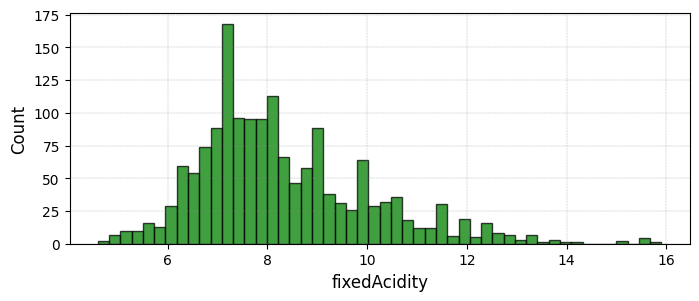

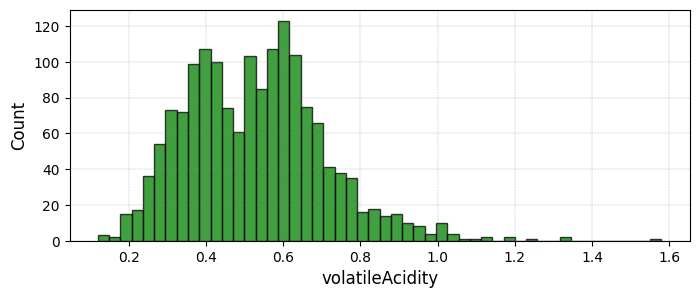

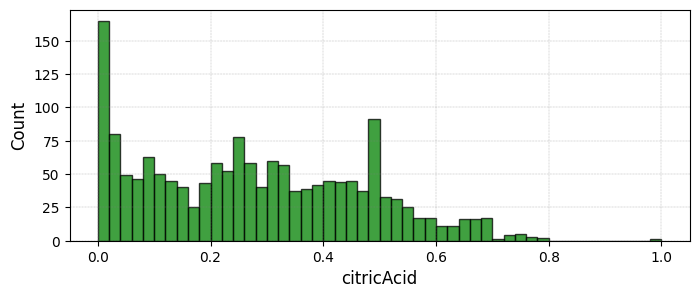

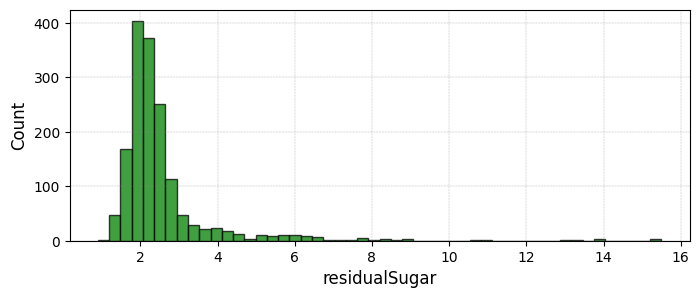

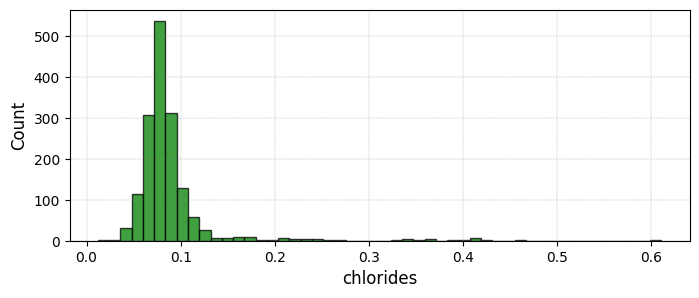

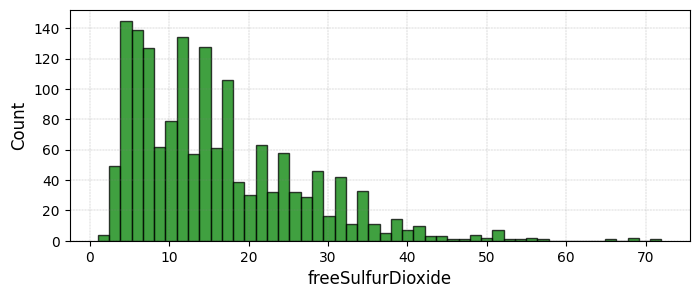

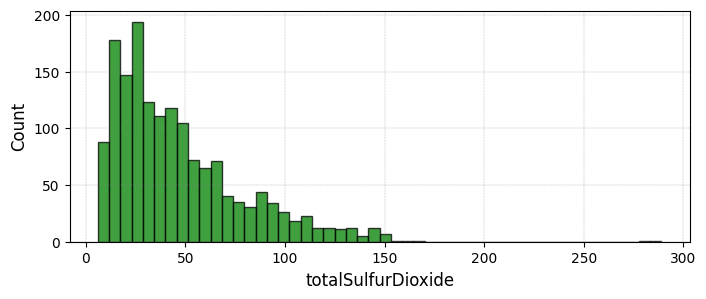

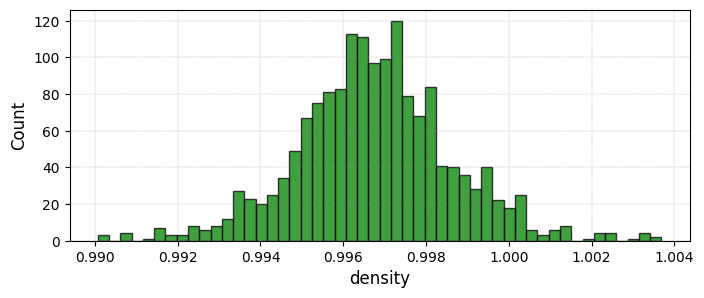

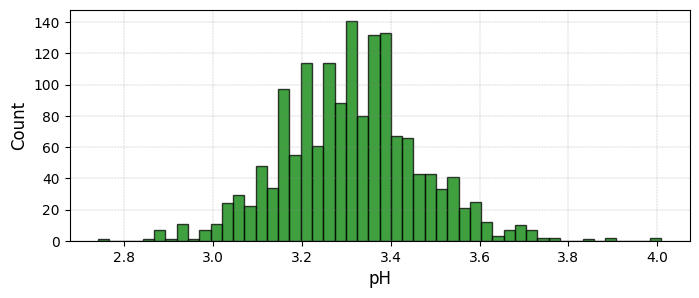

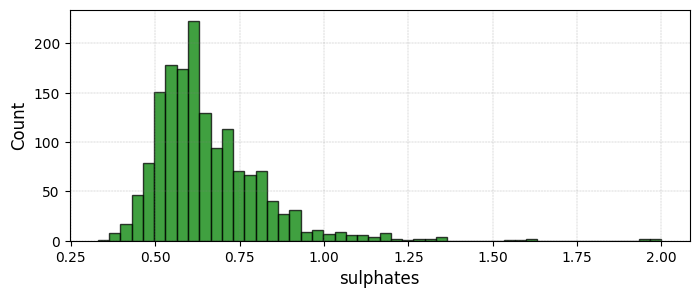

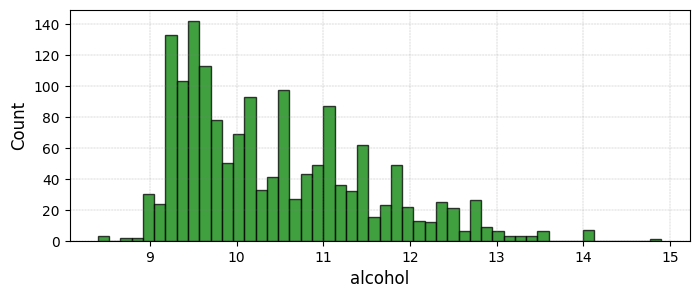

In [7]:
# plot continuous
for var in numeric:
    plt.figure(figsize=(8,3))
    plt.hist(df[var],50,facecolor='g', alpha=0.75, histtype='bar', ec='black')
    plt.ylabel('Count',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.show()

We can see that there are outliers in some of the variables.\
While we don't do anything about it here, we could proceed to treat outliers in the following form:\
1-Winsorizing or Clipping setting a threshold such that outside this threshold values are replaced with the threshold.\
2-Dropping Outliers using statistical methods.\
3-Transforming the data (logarithmic, square root, Box-Cox, ...) to have a more compressed distribution.

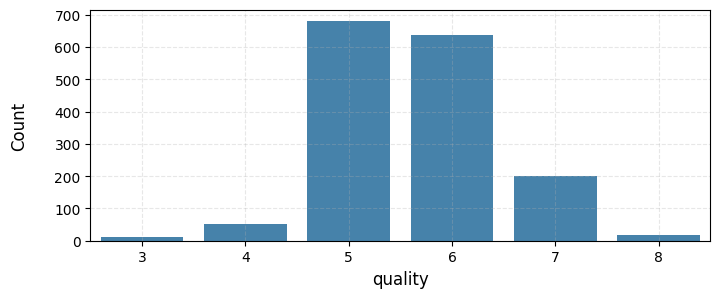

In [8]:
# plot categorical
for var in categorical:
    plt.figure(figsize=(8,3))
    count = df[var].value_counts()
    count.index=count.index.astype(int)
    sns.barplot(count[0:20],alpha=0.9)
    plt.ylabel('Count\n',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.show()

In [9]:
df[var].value_counts().sort_index()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

The above graph shows that the classes (quality) are imbalanced.\
There are many techniques to deal with imbalanced data:\
1- Resampling: Undersampling (remove samples from the over-represented classes) or Oversampling (generate new samples from the under-represented class).\
2- Weight classes: adjust class weights in the ML algorithm to address the class imbalance.\
3- Ensemble methods: bagging and boosting methods can improve the model's performance of the minority class.\
4- Use appropriate evaluation metrics: precision, recall, F1-score, or area under the ROC curve (AUC-ROC) which provide a more comprehensive view of model performance on imbalanced datasets.

In [10]:
# Multicollinearity test
# Variance Inflation Factor (VIF)
# VIF measures how much the variance of an estimated regression coefficient increases if predictors are correlated. 
# A high VIF indicates that a predictor variable is highly collinear with the other predictor variables.
vif_data = df.copy()
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

# Print the VIF values
print(vif)

              Variable          VIF
0         fixedAcidity    74.455312
1      volatileAcidity    17.960867
2           citricAcid     9.192549
3        residualSugar     4.664003
4            chlorides     6.641291
5    freeSulfurDioxide     6.460603
6   totalSulfurDioxide     6.605274
7              density  1528.154302
8                   pH  1078.171089
9            sulphates    22.462103
10             alcohol   147.616345
11             quality    77.728259


The Multicollinearity test shows that some variables in the dataset may be highly correlated, leading to potential issues in a classification analysis, such as overfitting, or model instability.\
The commonly used rule of thumb is that a Variance Inflation Factor (VIF) value above 10 indicates a problematic level of multicollinearity.\
If multicollinearity is detected, it can impact the stability and interpretability of the classification model. 

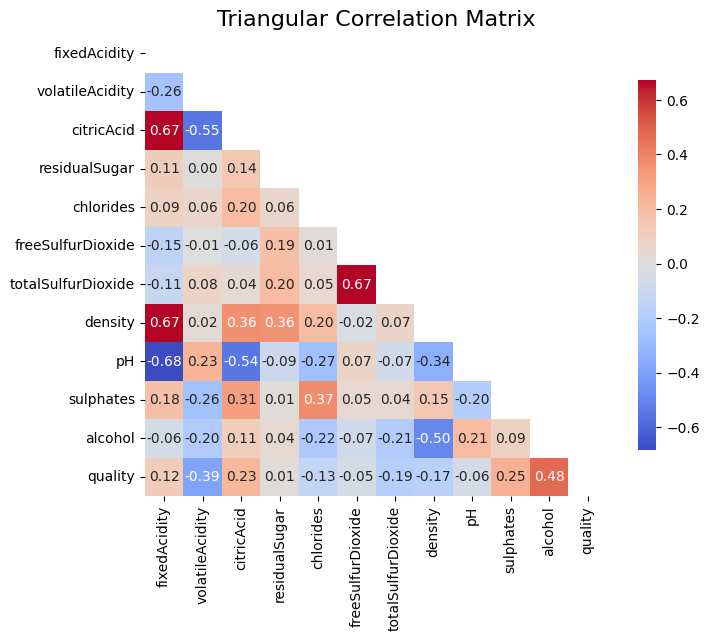

In [11]:
# Assuming df is your DataFrame
correlation_matrix = np.corrcoef(df, rowvar=False)

# Create a mask to hide the upper triangular part and the diagonal
mask = np.triu(np.ones_like(correlation_matrix), k=1)
correlation_matrix[np.eye(correlation_matrix.shape[0], dtype=bool)] = np.nan

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create a seaborn heatmap with the masked upper triangle and no diagonal
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"shrink": 0.8})

# Customize the plot (optional)
plt.title('Triangular Correlation Matrix', fontsize=16)

# Use original column names as tick labels and rotate them
plt.xticks(np.arange(correlation_matrix.shape[0]) + 0.5, labels=df.columns, rotation=90)
plt.yticks(np.arange(correlation_matrix.shape[0]) + 0.5, labels=df.columns, rotation=0)  # You can adjust the rotation angle here

# Adjust the aspect ratio to make the squares square
heatmap.set_aspect('equal')

plt.show()

The pairwise correlation analysis confirms the findings of the multicollinearity test.\
Approaches to address or mitigate multicollinearity:\
1- Remove highly correlated variables: of the highly correlated pairs of variables, keep just one.\
2- Use Principal Component Analysis (PCA) to transform the set of variables into a set of linearly uncorrelated variables (principal components).\
3- Exclude variables with the highest VIF values.\
4- Use L2 regularization (Ridge Regression): Ridge regression penalizes the sum of squared coefficients, distributing the impact of correlated variables more evenly, preventing one variable from dominating the others.

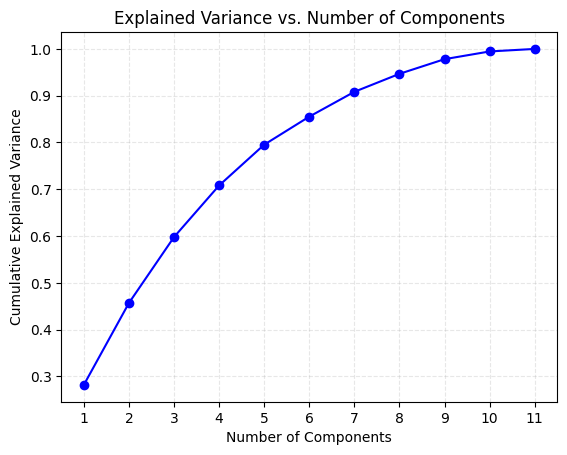

In [12]:
# Standardize the features
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df.loc[:, ~df.columns.isin(categorical)])

# Fit PCA
pca = PCA()
pca.fit(df_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot the explained variance and look for an elbow point
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True,alpha=0.3,linestyle='--')
# Set xticks for each component
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.show()

We will select the number of components to retain a variance of 90% of the total variance of the features.\
With this threshold we balance information retention and model complexity.

In [13]:
# Perform PCA with n_components=7
n_components = 7
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_standardized)

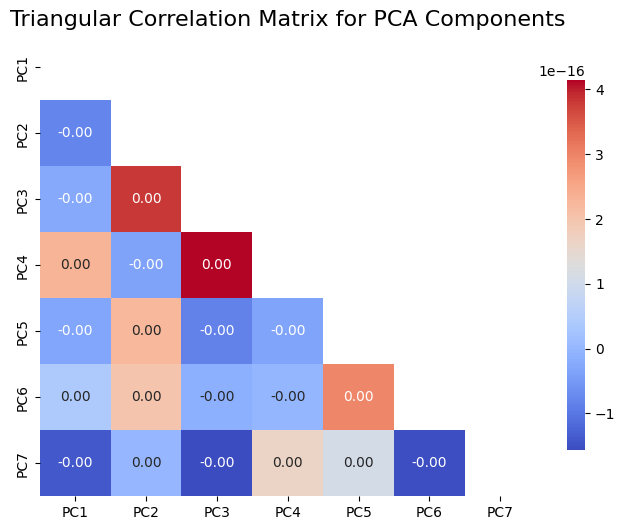

In [14]:
# Calculate the correlation matrix for df_pca
correlation_matrix = np.corrcoef(df_pca, rowvar=False)
# Create a mask to hide the upper triangular part and the diagonal
mask = np.triu(np.ones_like(correlation_matrix), k=1)
correlation_matrix[np.eye(correlation_matrix.shape[0], dtype=bool)] = np.nan
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))
# Create a seaborn heatmap with the masked upper triangle and no diagonal
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"shrink": 0.8})
# Customize the plot (optional)
plt.title('Triangular Correlation Matrix for PCA Components', fontsize=16)
# Center the ticks in the middle of the squares
tick_positions = np.arange(0.5, correlation_matrix.shape[0] + 0.5)
plt.xticks(tick_positions, labels=[f'PC{i+1}' for i in range(correlation_matrix.shape[0])])
plt.yticks(tick_positions, labels=[f'PC{i+1}' for i in range(correlation_matrix.shape[0])])
# Show the plot
plt.show()

We can see that the principal components are orthogonal (linearly uncorrelated) to each other.

In [15]:
# Calculate Pearson correlation
pearson_correlations = df.apply(lambda x: pearsonr(x, df[categorical[0]]).correlation)
# Calculate Spearman correlation
spearman_correlations = df.apply(lambda x: spearmanr(x, df[categorical[0]]).correlation)
# Calculate Mutual Information
mutual_info = df.apply(lambda x: mutual_info_regression(x.values.reshape(-1, 1), df[categorical[0]]))
columns_without_target = [col for col in df.columns if col != categorical[0]]
# Create a DataFrame to display the results
correlation_results = pd.DataFrame({
    'Feature': columns_without_target,
    'Pearson_Correlation': pearson_correlations.drop(index=['quality']),
    'Spearman_Correlation': spearman_correlations.drop(index=['quality']),
    'Mutual_Information': mutual_info.drop(columns=['quality']).T.squeeze()
}).reset_index(drop=True)
correlation_results

,Feature,Pearson_Correlation,Spearman_Correlation,Mutual_Information
0,fixedAcidity,0.124052,0.114084,0.057060
1,volatileAcidity,-0.390558,-0.380647,0.103030
2,citricAcid,0.226373,0.213481,0.044180
3,residualSugar,0.013732,0.032048,0.028478
4,chlorides,-0.128907,-0.189922,0.059152
5,freeSulfurDioxide,-0.050656,-0.056901,0.012240
6,totalSulfurDioxide,-0.185100,-0.196735,0.090495
7,density,-0.174919,-0.177074,0.096649
8,pH,-0.057731,-0.043672,0.013486
9,sulphates,0.251397,0.377060,0.114384


# Predicting

In [16]:
# Split the dataset into training and testing sets
X = df.loc[:, ~df.columns.isin(categorical)]
y = df[categorical[0]]
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, # df_pca
                                                    test_size=test_size, 
                                                    random_state=random_state)
mads = []
smapes = []
mses = []
mapes = []
accuracies = []

Evaluation Metrics:

MAD: Mean Absolute Deviation\
MSE: Mean Squared Error\
SMAPE: Symmetric Mean Absolute Percentage Error\
MAPE: Mean Absolute Percentage Error\
Accuracy

In [17]:
# Decision Tree model
dt_model = DecisionTreeRegressor(random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(dt_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
dt = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
dt['Model'] = "Decision Tree"
dt['Metric'] = scorers.keys()

In [18]:
# Random Forest model
rf_model = RandomForestRegressor(random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(rf_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
rf = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
rf['Model'] = "Random Forest"
rf['Metric'] = scorers.keys()

In [19]:
# Extra Trees model
extra_trees_model = ExtraTreesRegressor(random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(extra_trees_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
et = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
et['Model'] = "Extra Trees"
et['Metric'] = scorers.keys()

In [20]:
# xgb
xgb_model = XGBRegressor(
    seed=random_state
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(xgb_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
xgbm = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
xgbm['Model'] = "XGBoost"
xgbm['Metric'] = scorers.keys()

In [21]:
# Create LightGBM model
lgb_model = lgb.LGBMRegressor(
    random_state=random_state,
    force_col_wise=True
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(lgb_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
lgbm = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
lgbm['Model'] = "Light GBM"
lgbm['Metric'] = scorers.keys()

[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 1023, number of used features: 11
[LightGBM] [Info] Start training from score 0.007687
[LightGBM] [Info] Total Bins 975
[LightGBM] [Info] Number of data points in the train set: 1023, number of used features: 11
[LightGBM] [Info] Start training from score -0.021372
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 1023, number of used features: 11
[LightGBM] [Info] Start training from score -0.001999
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1023, number of used features: 11
[LightGBM] [Info] Start training from score -0.026216
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 11
[LightGBM] [Info] Start training from score -0.033008
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 1023, number of

In [22]:
# Create MLP model
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100,),
    max_iter=300,
    random_state=42
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(mlp_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
mlp = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
mlp['Model'] = "MLP"
mlp['Metric'] = scorers.keys()

c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

In [23]:
# Create MLP model with zero hidden layers (equivalent to Linear Regression)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(),  # Empty tuple means zero hidden layers
    max_iter=300,
    random_state=42
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(mlp_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
lr = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
lr['Model'] = "Linear Regression"
lr['Metric'] = scorers.keys()

c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\manuz\Desktop\Adm\JobMarket\Jobs\Ofqual\myvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

In [24]:
# Create the SVM model
svm_model = SVR(kernel='rbf', C=3)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mads = []
smapes = []
mses = []
mapes = []
accuracies = []

def accuracy_within_tolerance(y_true, y_pred, scaler_y, tolerance):
    y_true_orig_scale = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    within_tolerance = np.sum(np.abs(y_true_orig_scale - y_pred_orig_scale) <= tolerance)
    total_samples = len(y_true)
    accuracy = within_tolerance / total_samples * 100
    return accuracy

# Update the scorers dictionary
scorers = {
    'mad': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(calculate_mape),
    'smape': make_scorer(calculate_smape),
    'accuracy_within_tolerance': make_scorer(accuracy_within_tolerance, scaler_y=scaler_y, tolerance=tolerance)
}

for run in range(num_runs):
    # Perform 5-fold cross-validation and get the scores for each metric
    cv_results = cross_validate(svm_model, X_train, y_train, cv=kf, scoring=scorers)
    mads.append(cv_results['test_mad'])
    mses.append(cv_results['test_mse'])
    mapes.append(cv_results['test_mape'])
    smapes.append(cv_results['test_smape'])
    accuracies.append(cv_results['test_accuracy_within_tolerance'])

average_mad = np.mean(mads)
average_mse = np.mean(mses)
average_mape = np.mean(mapes)
average_smape = np.mean(smapes)
average_accuracy = np.mean(accuracies)

confidence_interval_mad = t.interval(confidence_level, degrees_of_freedom, loc=average_mad, scale=np.std(mads))
confidence_interval_mse = t.interval(confidence_level, degrees_of_freedom, loc=average_mse, scale=np.std(mses))
confidence_interval_mape = t.interval(confidence_level, degrees_of_freedom, loc=average_mape, scale=np.std(mapes))
confidence_interval_smape = t.interval(confidence_level, degrees_of_freedom, loc=average_smape, scale=np.std(smapes))
confidence_interval_accuracy = t.interval(confidence_level, degrees_of_freedom, loc=average_accuracy, scale=np.std(accuracies))
svm = pd.DataFrame({'average': [average_mad, average_mse, average_mape, average_smape, average_accuracy]
                    , 'upper': [confidence_interval_mad[1], confidence_interval_mse[1], confidence_interval_mape[1], confidence_interval_smape[1], confidence_interval_accuracy[1]]
                    , 'lower': [confidence_interval_mad[0], confidence_interval_mse[0], confidence_interval_mape[0], confidence_interval_smape[0], confidence_interval_accuracy[0]]})
svm['Model'] = "SVM"
svm['Metric'] = scorers.keys()

In [48]:
df = pd.concat([dt, rf, et, xgbm, lgbm, svm, mlp, lr], axis = 0, ignore_index=True)
df

,average,upper,lower,Model,Metric,yerr
0,0.601473,0.690451,0.512495,Decision Tree,mad,0.088978
1,1.020957,1.234246,0.807669,Decision Tree,mse,0.213288
2,85.126982,98.952226,71.301738,Decision Tree,mape,13.825244
3,68.055777,79.061306,57.050248,Decision Tree,smape,11.005529
4,59.339461,65.016642,53.662280,Decision Tree,accuracy_within_tolerance,5.677181
5,0.534260,0.582473,0.486047,Random Forest,mad,0.048213
6,0.552870,0.649688,0.456051,Random Forest,mse,0.096819
7,70.048541,76.760785,63.336297,Random Forest,mape,6.712244
8,86.317126,93.806506,78.827747,Random Forest,smape,7.489380
9,69.582721,74.558206,64.607235,Random Forest,accuracy_within_tolerance,4.975486


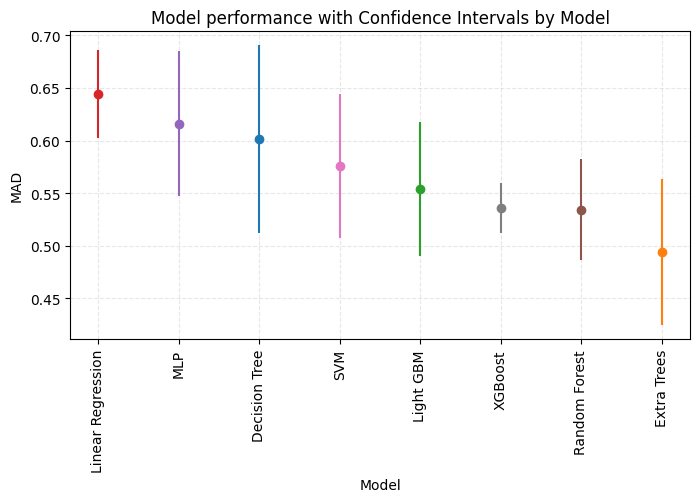

In [55]:
# Filter the DataFrame for the 'mad' metric
mad_df = df[df['Metric'] == 'mad']
mad_df = mad_df.sort_values(by=['average'], ascending=False)
mad_df = mad_df.reset_index(drop=True)
# Create a plot for each model
plt.figure(figsize=(8, 4))
for model, group in mad_df.groupby('Model'):
    plt.errorbar(x=group.index, y=group['average'], yerr=[group['average'] - group['lower'], group['upper'] - group['average']], fmt='o-', label=model)
# Set labels and title
plt.xlabel("Model")
plt.ylabel("MAD")
plt.title("Model performance with Confidence Intervals by Model")
plt.xticks(mad_df.index, mad_df.Model, rotation=90)
plt.grid(True, alpha=0.3, linestyle='--')
# Show the plot
plt.show()

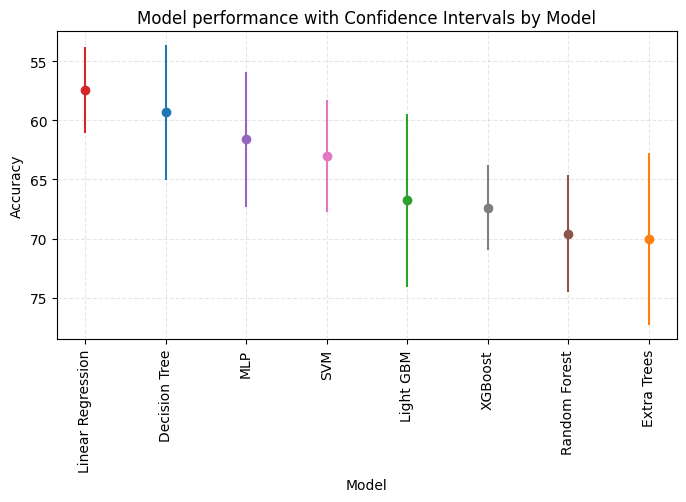

In [68]:
# Filter the DataFrame for the 'accuracy' metric
accuracy_df = df[df['Metric'] == 'accuracy_within_tolerance']
accuracy_df = accuracy_df.sort_values(by=['average'], ascending=True)
accuracy_df = accuracy_df.reset_index(drop=True)
# Create a plot for each model
plt.figure(figsize=(8, 4))
for model, group in accuracy_df.groupby('Model'):
    plt.errorbar(x=group.index, y=group['average'], yerr=[group['average'] - group['lower'], group['upper'] - group['average']], fmt='o-', label=model)
# Set labels and title
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model performance with Confidence Intervals by Model")
plt.xticks(accuracy_df.index, accuracy_df.Model, rotation=90)
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()
# Show the plot
plt.show()

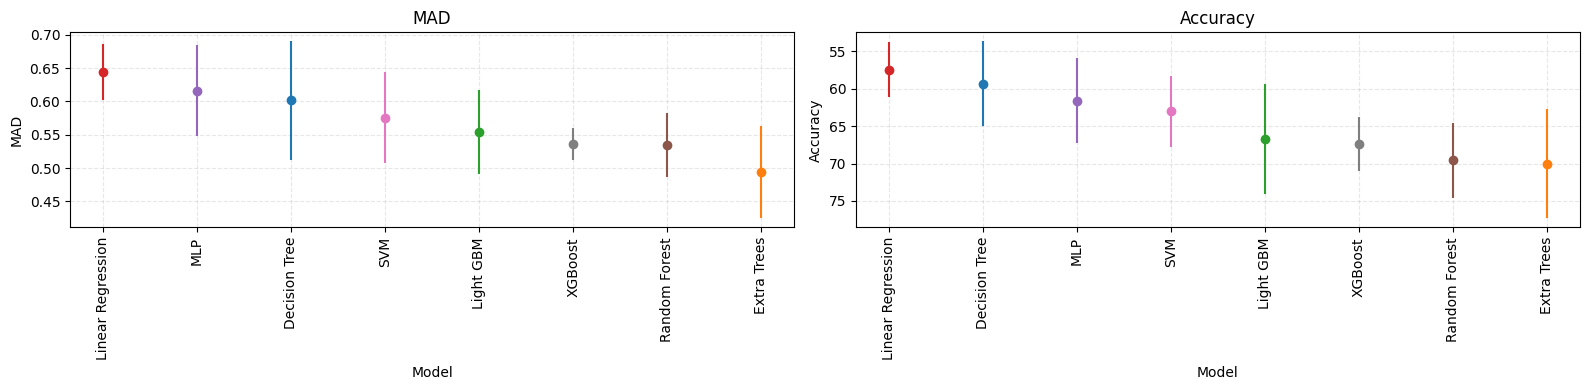

In [67]:
# Filter the DataFrame for the 'mad' metric
mad_df = df[df['Metric'] == 'mad']
mad_df = mad_df.sort_values(by=['average'], ascending=False)
mad_df = mad_df.reset_index(drop=True)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plot for 'mad' metric
axes[0].set_title("MAD")
for model, group in mad_df.groupby('Model'):
    axes[0].errorbar(x=group.index, y=group['average'], yerr=[group['average'] - group['lower'], group['upper'] - group['average']], fmt='o-', label=model)
axes[0].set_xlabel("Model")
axes[0].set_ylabel("MAD")
axes[0].set_xticks(mad_df.index)
axes[0].set_xticklabels(mad_df.Model, rotation=90)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Filter the DataFrame for the 'accuracy' metric
accuracy_df = df[df['Metric'] == 'accuracy_within_tolerance']
accuracy_df = accuracy_df.sort_values(by=['average'], ascending=True)
accuracy_df = accuracy_df.reset_index(drop=True)

# Plot for 'accuracy' metric
axes[1].set_title("Accuracy")
for model, group in accuracy_df.groupby('Model'):
    axes[1].errorbar(x=group.index, y=group['average'], yerr=[group['average'] - group['lower'], group['upper'] - group['average']], fmt='o-', label=model)
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Accuracy")
axes[1].set_xticks(accuracy_df.index)
axes[1].set_xticklabels(accuracy_df.Model, rotation=90)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].invert_yaxis()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()